In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from transformers import TFDistilBertModel, DistilBertTokenizer

In [2]:
pip install transformers  

Note: you may need to restart the kernel to use updated packages.


## 데이터 준비

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 가공

In [15]:

print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [16]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [9]:
# 문장 길이 분포 분석
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]
all_lengths = train_lengths + test_lengths
max_length = max(all_lengths)

print(f"문장 길이 분포: 최소 {min(all_lengths)}, 최대 {max(all_lengths)}, 평균 {np.mean(all_lengths)}")
print(f"적절한 최대 문장 길이: {max_length}")


문장 길이 분포: 최소 0, 최대 116, 평균 15.96940191154864
적절한 최대 문장 길이: 116


In [10]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [11]:
##word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index[0]='<PAD>'  # 패딩용 단어
word_to_index[1]='<BOS>'  # 문장의 시작지점
word_to_index[2]='<UNK>'  # 사전에 없는(Unknown) 단어
word_to_index[3] ='<UNUSED>'

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[4])   

print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [12]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:

# 패딩을 적용할 때 '<PAD>' 토큰의 인덱스를 사용
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)


KeyError: '<PAD>'

## 모델 구성 및 validation set 구성

In [ ]:
#철희 simple RNN
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_rnn = tf.keras.Sequential()
# [[YOUR CODE]]
## embedding
model_rnn.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))

model_rnn.add(tf.keras.layers.SimpleRNN(64))

model_rnn.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


model_rnn.summary()


In [ ]:
## GRU

# GRU 모델 설계
model_gru = tf.keras.Sequential()

# Embedding Layer
model_gru.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))

# GRU Layer
model_gru.add(tf.keras.layers.GRU(64))  # 64는 GRU 유닛 수 (하이퍼파라미터로 조정 가능)

# Dense Layers
model_gru.add(tf.keras.layers.Dense(64, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gru.summary()


In [ ]:
## disti-bert 


# DistilBERT Tokenizer와 Pretrained 모델 불러오기
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# DistilBERT 모델 설계
input_ids = tf.keras.Input(shape=(512,), dtype='int32')  # 입력 토큰의 크기 지정
attention_mask = tf.keras.Input(shape=(512,), dtype='int32')  # 어텐션 마스크 추가

# DistilBERT 모델 적용
bert_output = bert_model(input_ids, attention_mask=attention_mask)
cls_token = bert_output.last_hidden_state[:, 0, :]  # CLS 토큰 출력 가져오기

# Dense Layers
dense = tf.keras.layers.Dense(64, activation='relu')(cls_token)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 최종 모델 정의
model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_bert.summary()




In [ ]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

## 모델 훈련 개시

In [39]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 10s 37ms/step - loss: 0.0569 - accuracy: 0.9790 - val_loss: 1.0915 - val_accuracy: 0.8075
Epoch 2/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0487 - accuracy: 0.9819 - val_loss: 1.0699 - val_accuracy: 0.8081
Epoch 3/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0452 - accuracy: 0.9836 - val_loss: 1.1498 - val_accuracy: 0.8079
Epoch 4/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0480 - accuracy: 0.9823 - val_loss: 1.1610 - val_accuracy: 0.8092
Epoch 5/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0460 - accuracy: 0.9829 - val_loss: 1.2624 - val_accuracy: 0.8087
Epoch 6/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0459 - accuracy: 0.9833 - val_loss: 1.1245 - val_accuracy: 0.8048
Epoch 7/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0450 - accuracy: 0.9833 - val_loss: 1.1784 - val_accuracy:

KeyboardInterrupt: 

In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.9235 - accuracy: 0.8071
[0.9234678149223328, 0.8071485161781311]


In [35]:
## gru
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 11s 37ms/step - loss: 0.0700 - accuracy: 0.9745 - val_loss: 0.9353 - val_accuracy: 0.8091
Epoch 2/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0640 - accuracy: 0.9767 - val_loss: 0.9224 - val_accuracy: 0.8139
Epoch 3/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0616 - accuracy: 0.9778 - val_loss: 0.8569 - val_accuracy: 0.8122
Epoch 4/20
266/266 [==============================] - 10s 36ms/step - loss: 0.0563 - accuracy: 0.9792 - val_loss: 1.0061 - val_accuracy: 0.8021
Epoch 5/20
237/266 [=========================>....] - ETA: 1s - loss: 0.0542 - accuracy: 0.9799

KeyboardInterrupt: 

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

## Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


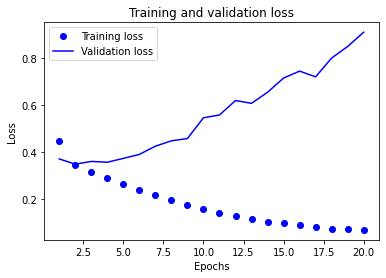

In [31]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

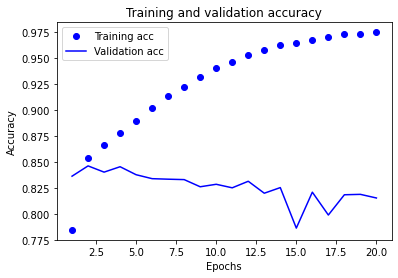

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 회고
전처리 부분에 에러가 많이 나서 word2vec 까지 못해봐서 아쉽다. 
끝나고 나서 사전 훈련된 모델인 word2vec과 disti-bert 둘 중에 어느 모델이 성능이 더 좋은지 확인해봐야 겠다. 
https://www.mindscale.kr/course/nlg/72
